# Example using G 75-21

In [1]:
%load_ext autoreload
%autoreload 2
    
from RVultra import RVultra, tools
import ultranest
import numpy as np
import pandas as pd

/Users/hugh/miniconda3/envs/radvelnest/lib/python3.9/site-packages/radvel/gp.py:32: ImportWarning: celerite not installed. GP kernals using celerite will not work. Try installing celerite using 'pip install celerite'
  warnings.warn("celerite not installed. GP kernals using celerite will not work. \


### Initialising the model

This is where key decisions about the model should be stored:

- Prior on semi-amplitude, `kprior` ('log' or 'linear')
- Prior on RV jitter, `jitterprior` ('log', 'linear', or None which follows the `kprior`)
- Prior on eccentricity, `ecc_prior` ('kipping', 'vaneylen', or None, which decides which one to use based on multiplicity)
- Whether to fit curvature, `fit_curv`
- Whether to fit a circular model, `fit_circ`, though this can also be selected specifically for individual planets
- The folder in which to store everything, `outfileloc`

In [2]:
lik=RVultra.Vector_PlanetLikelihood(name="G 75-21", kprior='log', fit_curv=True, fit_circ=False, outfileloc="G75-21")
                                    

## Adding stellar parameters:

In [3]:
lik.add_starpars(Ms=0.755, Rs=0.781)

## Adding various RV data:

There's a tonne of extra support for opening RV files in `tools`

In [4]:
sophdat, name = tools.extract_rvfile("G75-21/SophieRVs_TOI4317.csv")
lik.add_data(time=sophdat['time'].values,rvs=sophdat['mnvel'].values,rv_errs=sophdat['errvel'].values,instr="Sophie")
cordat, name = tools.extract_rvfile("G75-21/TIC422914082_COR14_DRS-3-8.rdb")
lik.add_data(time=cordat['time'].values,rvs=cordat['mnvel'].values,rv_errs=cordat['errvel'].values,instr="Coralie")
harpsdat, name = tools.extract_rvfile("G75-21/TIC422914082_HARPS15_DRS-3-0-0.rdb")
lik.add_data(time=harpsdat['time'].values,rvs=harpsdat['mnvel'].values,rv_errs=harpsdat['errvel'].values,instr="HARPS")
harpsndat, name = tools.extract_rvfile("G75-21/TOI-4317_harpn_drs.rdb")
lik.add_data(time=harpsndat['time'].values,rvs=harpsndat['mnvel'].values,rv_errs=harpsndat['errvel'].values,instr="HARPSN")

SOPHIE G75-21/SophieRVs_TOI4317.csv
COR G75-21/TIC422914082_COR14_DRS-3-8.rdb
HARPS G75-21/TIC422914082_HARPS15_DRS-3-0-0.rdb
HARPS-N G75-21/TOI-4317_harpn_drs.rdb


## Adding the planets to the model:

Here, we split transiting and non-transiting planets, as the transit duration can tell us something about the planetary velocity (and therefore eccentricity). 

It is also necessary to specify exactly which parameters to hold fixed (using `fix_params`), and which ones to model (using `model_params`).

For RV planets where we are modelling the period and tcen, we can specify the uncertainties in those parameters which are used as a uniform prior input. 

In [5]:
#A transiting planet where we will fix the period and tc using our knowledge from the transits:
lik.add_transiting_planet(plname='b', per=23.885495, tcen=2459148.11893, Rp_Rs=0.04098, tdur=0.17385, bmu=0.45536, bsigma=0.21804,
                          model_params=['logk'], fix_params=['per','tc'], fit_circ=True)

#An RV-only (i.e. non-transiting planet) where we will model the period and tc, but keep the orbit circular:
lik.add_rv_planet(plname='c', per=34.8, tcen=2460331.3, e_per=0.1*34.8, e_tcen=0.55*34.8,
                  model_params=['per','tc','logk'],fit_circ=True)

### Getting ready to sample

Once the model is ready, we need to initialise it:

In [6]:
lik.init_model()

#### Checking the model parameters using `lik.varpars`

In [7]:
lik.varpars

{'logk_b': ['uniform', -0.15528426645013516, 3.4891064832413314],
 'per_c': ['uniform', 31.319999999999997, 38.279999999999994],
 'tc_c': ['uniform', 2460312.1599999997, 2460350.44],
 'logk_c': ['uniform', -0.15528426645013516, 3.4891064832413314],
 'logjitter_Coralie': ['norm', 2.977133636170986, 0.5],
 'offset_Coralie': ['norm', 76761.342368, 15.80832409145571],
 'logjitter_HARPS': ['norm', 1.3455331720426138, 0.5],
 'offset_HARPS': ['norm', 76739.807222, 5.813102514069161],
 'logjitter_HARPSN': ['norm', -0.05836344733929068, 0.5],
 'offset_HARPSN': ['norm', 76765.9249587909, 5.923608416251665],
 'logjitter_Sophie': ['norm', 2.1972245773362196, 0.5],
 'offset_Sophie': ['norm', 76658.5, 8.481597726843686],
 'polytrend': ['norm', 0.029384513044478155, 0.029400778254429445],
 'polycurv': ['norm', 0.0, 0.02161014404915328]}

## Initialising the Ultranest model

We now need to give the ultranest sampling code data from the `lik` model:
1) The variable names
2) The lik model itself,
3) A prior transform function which transforms unit 0->1 floats into each parameter via the desired prior
4) The directory to store the outputs
5) Whether to resume from a previous run (`resume=True`) or not (`resume=overwrite`)
6) `vectorized=True` which speeds up sampling enormously
7) The list of wrapped parameters, in our case the omega angles

In [8]:
fixsampler = ultranest.ReactiveNestedSampler(lik.varnames, lik, RVultra.VectorPriorTransform(lik.varpars), 
                                             log_dir=lik.outfileloc, resume=True,vectorized=True,
                                             wrapped_params=['w_' in par for par in lik.varnames])

## Running the sampler:

In [9]:
result = fixsampler.run()
fixsampler.print_results()

[ultranest] Resuming from 14436 stored points


[ultranest] Explored until L=-2e+02  .37 [-186.1755..-186.1748]*| it/evals=13920/6426716 eff=inf% N=400    0   0  0 0 0 
[ultranest] Likelihood function evaluations: 6426716
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -216 +- 0.1709
[ultranest] Effective samples strategy satisfied (ESS = 4224.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 398 minimum live points (dlogz from 0.13 to 0.55, need <0.5)
[ultranest]   logZ error budget: single: 0.25 bs:0.17 tail:0.01 total:0.17 required:<0.50
[ultranest] done iterating.

logZ = -215.990 +- 0.342
  single instance: logZ = -215.990 +- 0.246
  bootstrapped   : logZ = -216.018 +- 0.342
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    logk_b              : -0.16 │▁▁▁▁▂▂▂▂▂▂▂▃▃▄▃▄▅▅▅▇▆▆▇▇▇▆▅▄▄▃▂▁▁▁▁▁▁

## Creating plots from Ultranest:

In [10]:
fixsampler.plot_run()
fixsampler.plot_trace()
fixsampler.plot_corner()

## Creating plots from the RVs:

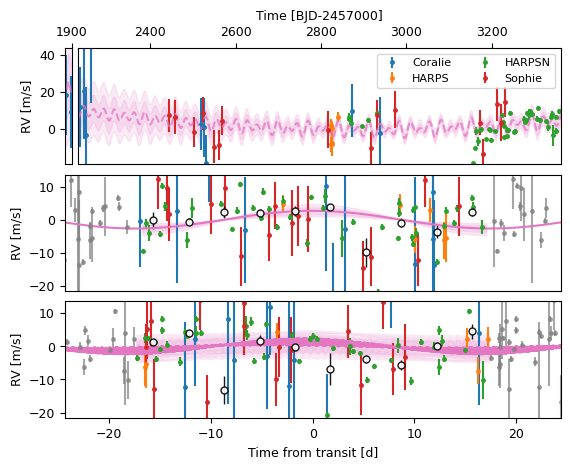

In [12]:
lik.plot(fixsampler.results['weighted_samples']['points'], fixsampler.results['weighted_samples']['weights'])

## Creating tables from the data

In [24]:
model_summary = lik.create_output_dict(fixsampler.results)
model_summary

,mean,sd,-2sig,-1sig,med,+1sig,+2sig,+3sig
logk_b,9.317443e-01,3.237467e-03,4.773932e-02,5.184436e-01,9.831982e-01,1.315329e+00,1.552772e+00,1.733784e+00
per_c,3.467814e+01,9.494188e-03,3.159948e+01,3.415468e+01,3.473808e+01,3.524312e+01,3.773976e+01,3.819294e+01
tc_c,2.460328e+06,4.495451e-02,2.460318e+06,2.460324e+06,2.460327e+06,2.460331e+06,2.460345e+06,2.460350e+06
logk_c,8.756643e-01,3.831121e-03,-7.095381e-02,3.282628e-01,9.588175e-01,1.343031e+00,1.599397e+00,1.753839e+00
logjitter_Coralie,2.476319e+00,3.183669e-03,1.670573e+00,2.099619e+00,2.484584e+00,2.856634e+00,3.209717e+00,3.488960e+00
offset_Coralie,7.675218e+04,6.597320e-02,7.673610e+04,7.674442e+04,7.675208e+04,7.676006e+04,7.676815e+04,7.677514e+04
logjitter_HARPS,1.314354e+00,3.534921e-03,4.078209e-01,8.921760e-01,1.327504e+00,1.736503e+00,2.102537e+00,2.390091e+00
offset_HARPS,7.674298e+04,2.138913e-02,7.673751e+04,7.674047e+04,7.674304e+04,7.674548e+04,7.674780e+04,7.674974e+04
logjitter_HARPSN,1.534722e+00,9.730398e-04,1.307538e+00,1.418750e+00,1.532332e+00,1.653826e+00,1.773126e+00,1.869976e+00
offset_HARPSN,7.676261e+04,1.184300e-02,7.675976e+04,7.676121e+04,7.676262e+04,7.676397e+04,7.676546e+04,7.676675e+04


## Comparing to a no-planet model:

In [30]:
flatlik.outfileloc

'/Users/hugh/python/RVultra/RVultra/RVultra.py/G75-21_noplanets'

In [31]:
flatvarpars={vpk:lik.varpars[vpk] for vpk in lik.varpars if vpk[:4] in ['poly','jitt','logj','offs']}#Taking only the non-planetary variables
#Copying the parameters from our with-planet model:
flatlik=RVultra.Vector_FlatLikelihood(name="G 75-21", data=lik.data, varnames=list(flatvarpars.keys()), 
                              jitprior=lik.kprior, fit_curv=lik.fit_curv)
flatsampler = ultranest.ReactiveNestedSampler(list(flatvarpars.keys()), flatlik, RVultra.VectorPriorTransform(flatvarpars), 
                                            log_dir=flatlik.outfileloc,
                                            resume=True, vectorized=True)
flatresult = flatsampler.run()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+02  .37 [-194.5070..-194.5055]*| it/evals=11700/183116 eff=6.4034% N=400   0   0  0 0  
[ultranest] Likelihood function evaluations: 183466
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -218.9 +- 0.1348
[ultranest] Effective samples strategy satisfied (ESS = 3212.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.23 bs:0.13 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.


TypeError: create_output_dict() missing 1 required positional argument: 'result'

In [33]:
flat_summary = flatlik.summarise_results(flatresult)
flat_summary

,mean,sd,-2sig,-1sig,med,+1sig,+2sig,+3sig
logjitter_Coralie,2.485752,3.443993e-03,1.712883e+00,2.110348,2.494974,2.864533,3.208108,3.465285
offset_Coralie,76752.504874,7.222108e-02,7.673679e+04,76744.757593,76752.419935,76760.349006,76768.713420,76774.901330
logjitter_HARPS,1.428207,3.614187e-03,5.693907e-01,1.047351,1.443932,1.817452,2.171254,2.432015
offset_HARPS,76741.831079,2.242365e-02,7.673648e+04,76739.504666,76741.912814,76744.246831,76746.546623,76748.685267
logjitter_HARPSN,1.668870,9.596779e-04,1.467347e+00,1.564201,1.664816,1.772684,1.888604,1.984518
offset_HARPSN,76762.685815,1.343176e-02,7.675957e+04,76761.237912,76762.706719,76764.117697,76765.557820,76766.730025
logjitter_Sophie,1.767049,3.306162e-03,9.697590e-01,1.412937,1.787829,2.121716,2.446793,2.639647
offset_Sophie,76655.097767,2.631393e-02,7.664937e+04,76652.233674,76655.104765,76657.995421,76660.966766,76663.371046
polytrend,0.003435,4.156345e-05,-5.485733e-03,-0.001211,0.003396,0.007987,0.012826,0.017431
polycurv,0.000021,1.026148e-07,-3.414862e-07,0.000010,0.000021,0.000033,0.000044,0.000053


## Model comparison between them:

In this case, a large (>5) positive Bayesian log Evidence shows that the planet model is favoured:

In [37]:
print("Difference in Bayesian log Evidence is {:.2f}".format(model_summary.loc['logEvidence','mean']-flat_summary.loc['logEvidence','mean']))
print("Planet model is {:.2f} times more probable.".format(np.exp(model_summary.loc['logEvidence','mean']-flat_summary.loc['logEvidence','mean'])))

Difference in Bayesian log Evidence is 2.89
Planet model is 17.97 times more probable.
